In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [2]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})


In [3]:
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]


In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
test_scaled  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)


In [5]:
LOOKBACK = 30
HORIZON  = 7   # multi-step forecast

def make_seq2seq(data, lookback, horizon):
    X, Y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i:i+horizon, 0])
    X = np.array(X, dtype=np.float32)[:, :, None]
    Y = np.array(Y, dtype=np.float32)
    return X, Y

X_train, y_train = make_seq2seq(train_scaled, LOOKBACK, HORIZON)
print(X_train.shape, y_train.shape)


(140, 30, 1) (140, 7)


In [6]:
class Seq2SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dl = DataLoader(Seq2SeqDataset(X_train, y_train), batch_size=32, shuffle=True)


In [7]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c

class Decoder(nn.Module):
    def __init__(self, hidden_size=64, horizon=7):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.horizon = horizon

    def forward(self, h, c):
        inputs = torch.zeros(h.size(1), 1, 1).to(h.device)
        outputs = []
        for _ in range(self.horizon):
            out, (h, c) = self.lstm(inputs, (h, c))
            y = self.fc(out)
            outputs.append(y.squeeze(2))
            inputs = y
        return torch.cat(outputs, dim=1)

class Seq2Seq(nn.Module):
    def __init__(self, horizon=7, hidden_size=64):
        super().__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, horizon)

    def forward(self, x):
        h, c = self.encoder(x)
        return self.decoder(h, c)

model = Seq2Seq(horizon=HORIZON).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
EPOCHS = 25
model.train()

for epoch in range(1, EPOCHS + 1):
    losses = []
    for xb, yb in dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()

        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | loss {np.mean(losses):.6f}")


epoch 01 | loss 0.232510
epoch 05 | loss 0.043284
epoch 10 | loss 0.035364
epoch 15 | loss 0.031279
epoch 20 | loss 0.017633
epoch 25 | loss 0.013748


In [9]:
model.eval()

window = train_scaled[-LOOKBACK:].copy()
preds = []

steps = len(test) // HORIZON
for _ in range(steps):
    X = torch.from_numpy(window.reshape(1, LOOKBACK, 1)).float().to(device)
    with torch.no_grad():
        yhat = model(X).cpu().numpy()[0]
    preds.extend(yhat)
    window = np.vstack([window[HORIZON:], yhat.reshape(-1,1)])

preds = np.array(preds[:len(test)], dtype=np.float32)
pred = scaler.inverse_transform(preds.reshape(-1,1)).reshape(-1)


In [10]:
mae  = mean_absolute_error(test.values[:len(pred)], pred)
rmse = np.sqrt(mean_squared_error(test.values[:len(pred)], pred))
mape = np.mean(np.abs((test.values[:len(pred)] - pred) / np.maximum(test.values[:len(pred)], 1e-8))) * 100

print("Seq2Seq LSTM Metrics")
print(f"Horizon: {HORIZON}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


Seq2Seq LSTM Metrics
Horizon: 7
MAE  : 7.08
RMSE : 8.54
MAPE : 8.15%


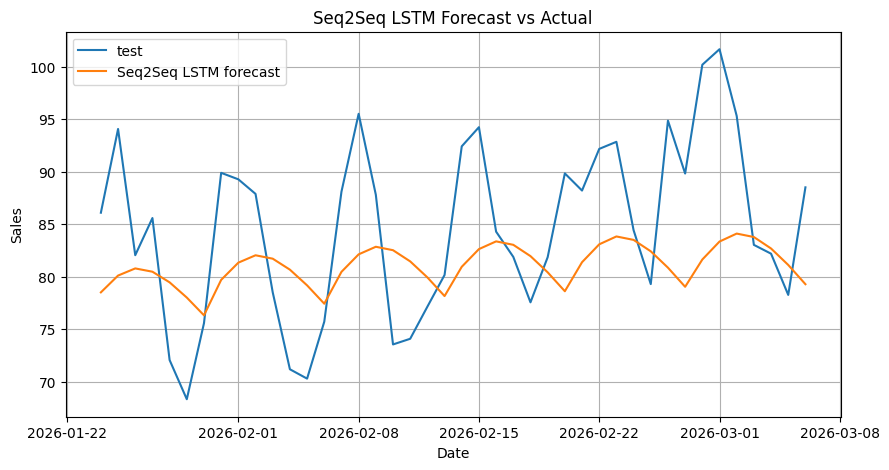

In [11]:
plt.figure(figsize=(10,5))
plt.plot(test.index[:len(pred)], test.values[:len(pred)], label="test")
plt.plot(test.index[:len(pred)], pred, label="Seq2Seq LSTM forecast")
plt.title("Seq2Seq LSTM Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True)
plt.show()
